In [2]:
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
import cmasher as cmr

from convolution import gauss_2d_kernel
from astropy.convolution import Gaussian2DKernel, Box2DKernel, convolve, interpolate_replace_nans

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

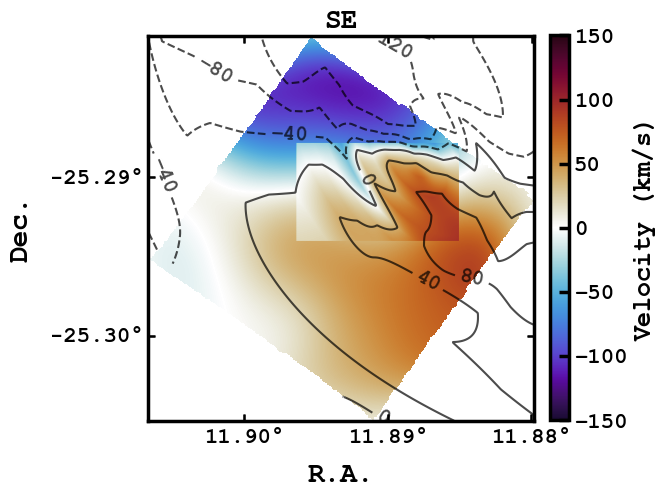

In [5]:
# cmap = 'RdBu_r'
# cmap = cmr.viola
cmap = cmr.fusion_r
vmin = -150
vmax = 150

# read in the data cubes
south_cube = fits.open('../ngc253/data/ADP.2018-11-22T21_29_46.157.fits')
CO_cube = fits.open('../ngc253/data/NGC253.CO_1-0.diskfit.total_model_NKrieger.fits')

# we want the CO cube to just have 2 axes (RA and Dec)
w = wcs.WCS(CO_cube[0].header, naxis=2).celestial
CO_cube_new = fits.PrimaryHDU(data=CO_cube[0].data, header=w.to_header())

# ============================================
# SOUTH
# ============================================

# we also want our cube to just have 2 axes (RA and Dec)
w_south = wcs.WCS(south_cube[1].header, naxis=2).celestial
south_cube_header = w_south.to_header()
z_south, y_south, x_south = south_cube[1].shape

# now open the CO cube and reproject it into the footprint
# of our cube using the wcs information
CO_cube_array_south, footprint_south = reproject_interp(CO_cube_new, south_cube_header, shape_out=(y_south,x_south))

# convert from LSRK to Barycentric frame to match our data
# https://docs.astropy.org/en/stable/api/astropy.coordinates.LSRK.html
CO_cube_array_south = CO_cube_array_south - 20  # km/s

# subtract the systemic velocity
CO_cube_array_south = CO_cube_array_south - 243  # km/s

# ============================================
# PLOT
# ============================================

fig = plt.figure(figsize=(5,5))

# read in our H-alpha velocity models
Halpha_cube_south = fits.open('../ngc253/data/ngc253_se_halpha_vel_model_smooth_FINAL.fits')
Halpha_cube_array_south = Halpha_cube_south[0].data
disk_map_infile = '../ngc253/data/Krieger19_CO_velocity_ngc253_vsys_barycentric.fits'
hdu_CO = fits.open(disk_map_infile)
CO_disk_map = hdu_CO[0].data

# disk_map = (Halpha_cube_array_south + CO_disk_map) / 2.
# disk_map = CO_disk_map
# disk_map = Halpha_cube_array_south + push_blue_up

# mask1 = (Halpha_cube_array_south - CO_disk_map) > 50
# mask2 = (Halpha_cube_array_south - CO_disk_map) < -50

# Halpha_cube_array_south[mask1] = Halpha_cube_array_south[mask1] - (Halpha_cube_array_south[mask1] - CO_disk_map[mask1])
# Halpha_cube_array_south[mask2] = Halpha_cube_array_south[mask2] + (Halpha_cube_array_south[mask2] - CO_disk_map[mask2])

Halpha_cube_array_south[204:315,168:352] = CO_disk_map[204:315,168:352] 

disk_map = Halpha_cube_array_south

# plot the SE model
ax = plt.subplot(1, 1, 1, projection=w_south)
im = ax.imshow(disk_map, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5)
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.set_title('SE',fontsize=20)

contours_south = ax.contour(CO_cube_array_south, 6, colors='k', alpha=0.7)
ax.clabel(contours_south, fontsize=15, inline=True)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

# plt.savefig('../ngc253/visuals/velocity_models.png', dpi=200)

# save the final, smoothed image as a fits file
hdul = fits.PrimaryHDU(data=disk_map, header=Halpha_cube_south[0].header)
hdul.writeto('../ngc253/data/ngc253_se_halpha_vel_model_smooth_replaceCO.fits', overwrite=True)
plt.show()

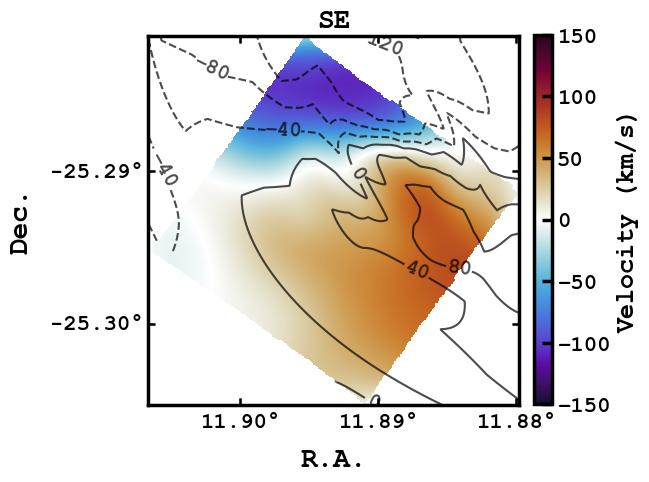

In [6]:
beam = 0.8889  # taken from the header
mask_kern = 10*beam  # sigma for 2D Gaussian kernel to do the masking
fill_kern = 20*beam  # sigma for 2D Gaussian kernel to fill in masked values

# build the kernel
kern_arr = gauss_2d_kernel(sigma=mask_kern)

# convolve with the original map; this will find pixels that deviate
# a lot from their neighbors
new_image = convolve(disk_map, kern_arr, normalize_kernel=False, 
                     nan_treatment='fill')

# set a threshold: we want to find pixels that deviate by +/- 100
# blank out these pixels; this is our mask!
mask = np.abs(new_image) < 100
copy_im = disk_map.copy()
copy_im[~mask] = np.nan

# fill in the final stuff
kernel = Gaussian2DKernel(fill_kern)
final_image = convolve(copy_im, kernel)
final_image[np.isnan(disk_map)] = np.nan # [0] has some nans within

# plot the SE model
ax = plt.subplot(1, 1, 1, projection=w_south)
im = ax.imshow(final_image, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5)
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.set_title('SE',fontsize=20)

contours_south = ax.contour(CO_cube_array_south, 6, colors='k', alpha=0.7)
ax.clabel(contours_south, fontsize=15, inline=True)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

# plt.savefig('../ngc253/visuals/velocity_models.png', dpi=200)

# save the final, smoothed image as a fits file
hdul = fits.PrimaryHDU(data=final_image, header=Halpha_cube_south[0].header)
hdul.writeto('../ngc253/data/ngc253_se_halpha_vel_model_smooth_replaceCO_andsmooth.fits', overwrite=True)
plt.show()